In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, accuracy_score
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers, Sequential
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [3]:
df = pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
#Checking the shape of data
df.shape

(284807, 31)

In [5]:
#Checking for null values
df.isnull().values.any()

False

Text(0, 0.5, 'Frequency')

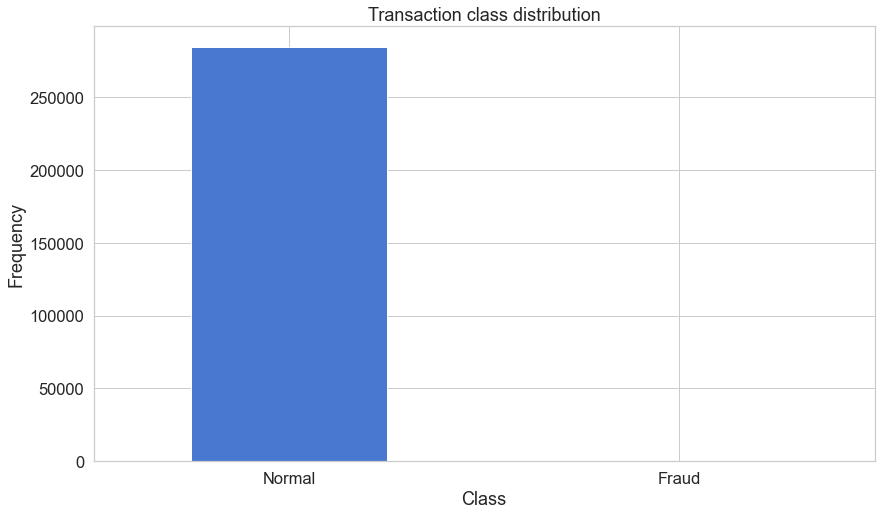

In [6]:
count_classes = pd.value_counts(df['Class'])
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

In [7]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]
frauds.shape

(492, 31)

In [8]:
normal.shape

(284315, 31)

In [9]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [10]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

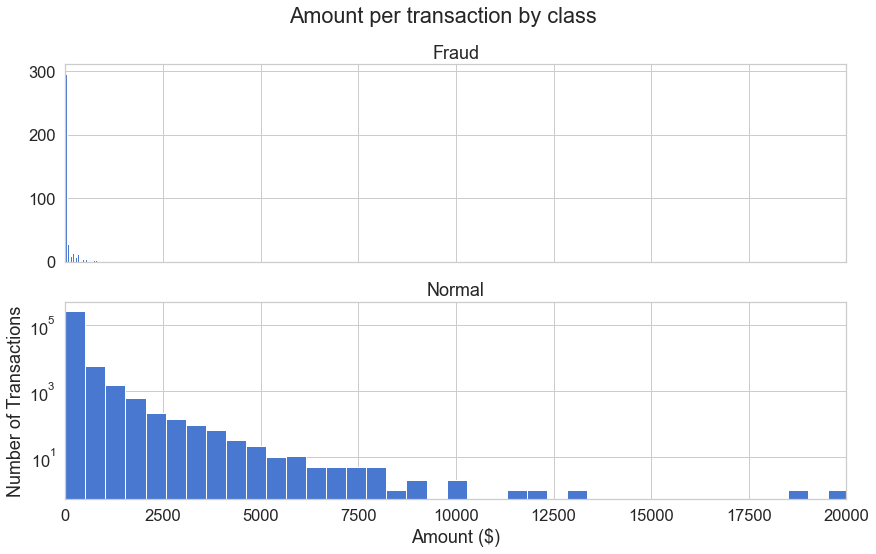

In [11]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show()

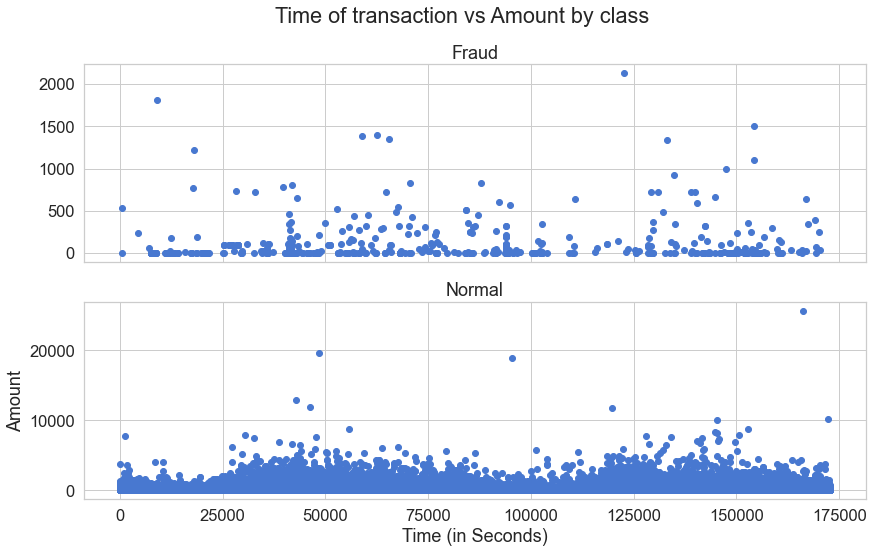

In [12]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()


In [13]:
data = df.drop(['Time'], axis=1)

In [14]:
from sklearn.preprocessing import StandardScaler

data['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))

In [15]:
non_fraud = data[data['Class'] == 0] #.sample(1000)
fraud = data[data['Class'] == 1]

df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)
X = df.drop(['Class'], axis = 1).values
Y = df["Class"].values


In [16]:
X_train, X_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
X_train_fraud = X_train[X_train.Class == 1]
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_train = X_train.values
X_test = X_test.values
X_train.shape

(227451, 29)

In [17]:
input_layer = Input(shape=(X.shape[1],))

## encoding part
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)

## decoding part
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

## output layer
output_layer = Dense(X.shape[1], activation='relu')(decoded)

In [18]:
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")

In [19]:
x = data.drop(["Class"], axis=1)
y = data["Class"].values

x_scale = MinMaxScaler().fit_transform(x.values)
x_norm, x_fraud = x_scale[y == 0], x_scale[y == 1]

autoencoder.fit(x_norm[0:2000], x_norm[0:2000], 
                batch_size =1024, epochs = 1000, 
                shuffle = True, validation_split = 0.20);

Epoch 1/1000
2/2 [==============================] - 30s 7s/step - loss: 0.2305 - val_loss: 0.2293
Epoch 2/1000
2/2 [==============================] - 0s 343ms/step - loss: 0.2303 - val_loss: 0.2292
Epoch 3/1000
2/2 [==============================] - 0s 72ms/step - loss: 0.2302 - val_loss: 0.2291
Epoch 4/1000
2/2 [==============================] - 0s 51ms/step - loss: 0.2302 - val_loss: 0.2290
Epoch 5/1000
2/2 [==============================] - 0s 58ms/step - loss: 0.2300 - val_loss: 0.2289
Epoch 6/1000
2/2 [==============================] - 0s 37ms/step - loss: 0.2299 - val_loss: 0.2288
Epoch 7/1000
2/2 [==============================] - ETA: 0s - loss: 0.229 - 0s 112ms/step - loss: 0.2298 - val_loss: 0.2286
Epoch 8/1000
2/2 [==============================] - 0s 50ms/step - loss: 0.2297 - val_loss: 0.2285
Epoch 9/1000
2/2 [==============================] - 0s 80ms/step - loss: 0.2295 - val_loss: 0.2284
Epoch 10/1000
2/2 [==============================] - 0s 37ms/step - loss: 0.2295 - v

Epoch 83/1000
2/2 [==============================] - 0s 35ms/step - loss: 0.2198 - val_loss: 0.2187
Epoch 84/1000
2/2 [==============================] - 0s 37ms/step - loss: 0.2197 - val_loss: 0.2185
Epoch 85/1000
2/2 [==============================] - 0s 35ms/step - loss: 0.2195 - val_loss: 0.2184
Epoch 86/1000
2/2 [==============================] - 0s 35ms/step - loss: 0.2194 - val_loss: 0.2182
Epoch 87/1000
2/2 [==============================] - 0s 36ms/step - loss: 0.2192 - val_loss: 0.2181
Epoch 88/1000
2/2 [==============================] - 0s 39ms/step - loss: 0.2190 - val_loss: 0.2179
Epoch 89/1000
2/2 [==============================] - 0s 36ms/step - loss: 0.2189 - val_loss: 0.2177
Epoch 90/1000
2/2 [==============================] - 0s 36ms/step - loss: 0.2187 - val_loss: 0.2176
Epoch 91/1000
2/2 [==============================] - 0s 36ms/step - loss: 0.2185 - val_loss: 0.2174
Epoch 92/1000
2/2 [==============================] - 0s 37ms/step - loss: 0.2183 - val_loss: 0.2172


2/2 [==============================] - 0s 36ms/step - loss: 0.2028 - val_loss: 0.2017
Epoch 165/1000
2/2 [==============================] - 0s 37ms/step - loss: 0.2025 - val_loss: 0.2014
Epoch 166/1000
2/2 [==============================] - 0s 36ms/step - loss: 0.2022 - val_loss: 0.2011
Epoch 167/1000
2/2 [==============================] - 0s 38ms/step - loss: 0.2018 - val_loss: 0.2007
Epoch 168/1000
2/2 [==============================] - 0s 36ms/step - loss: 0.2015 - val_loss: 0.2004
Epoch 169/1000
2/2 [==============================] - 0s 36ms/step - loss: 0.2013 - val_loss: 0.2001
Epoch 170/1000
2/2 [==============================] - 0s 36ms/step - loss: 0.2009 - val_loss: 0.1998
Epoch 171/1000
2/2 [==============================] - 0s 35ms/step - loss: 0.2006 - val_loss: 0.1995
Epoch 172/1000
2/2 [==============================] - 0s 37ms/step - loss: 0.2004 - val_loss: 0.1992
Epoch 173/1000
2/2 [==============================] - 0s 35ms/step - loss: 0.2001 - val_loss: 0.1989
Epoch

2/2 [==============================] - 0s 34ms/step - loss: 0.1801 - val_loss: 0.1789
Epoch 246/1000
2/2 [==============================] - 0s 35ms/step - loss: 0.1798 - val_loss: 0.1787
Epoch 247/1000
2/2 [==============================] - 0s 35ms/step - loss: 0.1795 - val_loss: 0.1784
Epoch 248/1000
2/2 [==============================] - 0s 36ms/step - loss: 0.1793 - val_loss: 0.1782
Epoch 249/1000
2/2 [==============================] - 0s 34ms/step - loss: 0.1791 - val_loss: 0.1779
Epoch 250/1000
2/2 [==============================] - 0s 35ms/step - loss: 0.1788 - val_loss: 0.1777
Epoch 251/1000
2/2 [==============================] - 0s 35ms/step - loss: 0.1785 - val_loss: 0.1774
Epoch 252/1000
2/2 [==============================] - 0s 37ms/step - loss: 0.1784 - val_loss: 0.1772
Epoch 253/1000
2/2 [==============================] - 0s 37ms/step - loss: 0.1781 - val_loss: 0.1769
Epoch 254/1000
2/2 [==============================] - 0s 40ms/step - loss: 0.1778 - val_loss: 0.1767
Epoch

2/2 [==============================] - 0s 37ms/step - loss: 0.1610 - val_loss: 0.1599
Epoch 327/1000
2/2 [==============================] - 0s 37ms/step - loss: 0.1608 - val_loss: 0.1597
Epoch 328/1000
2/2 [==============================] - 0s 37ms/step - loss: 0.1606 - val_loss: 0.1595
Epoch 329/1000
2/2 [==============================] - 0s 37ms/step - loss: 0.1604 - val_loss: 0.1593
Epoch 330/1000
2/2 [==============================] - 0s 37ms/step - loss: 0.1602 - val_loss: 0.1590
Epoch 331/1000
2/2 [==============================] - 0s 38ms/step - loss: 0.1600 - val_loss: 0.1588
Epoch 332/1000
2/2 [==============================] - 0s 50ms/step - loss: 0.1597 - val_loss: 0.1586
Epoch 333/1000
2/2 [==============================] - 0s 47ms/step - loss: 0.1595 - val_loss: 0.1584
Epoch 334/1000
2/2 [==============================] - 0s 46ms/step - loss: 0.1593 - val_loss: 0.1582
Epoch 335/1000
2/2 [==============================] - 0s 42ms/step - loss: 0.1591 - val_loss: 0.1580
Epoch

2/2 [==============================] - 0s 36ms/step - loss: 0.1446 - val_loss: 0.1435
Epoch 408/1000
2/2 [==============================] - 0s 39ms/step - loss: 0.1445 - val_loss: 0.1433
Epoch 409/1000
2/2 [==============================] - 0s 35ms/step - loss: 0.1443 - val_loss: 0.1432
Epoch 410/1000
2/2 [==============================] - 0s 36ms/step - loss: 0.1441 - val_loss: 0.1430
Epoch 411/1000
2/2 [==============================] - 0s 40ms/step - loss: 0.1438 - val_loss: 0.1428
Epoch 412/1000
2/2 [==============================] - 0s 40ms/step - loss: 0.1437 - val_loss: 0.1426
Epoch 413/1000
2/2 [==============================] - 0s 45ms/step - loss: 0.1435 - val_loss: 0.1424
Epoch 414/1000
2/2 [==============================] - 0s 38ms/step - loss: 0.1433 - val_loss: 0.1422
Epoch 415/1000
2/2 [==============================] - 0s 39ms/step - loss: 0.1432 - val_loss: 0.1420
Epoch 416/1000
2/2 [==============================] - 0s 37ms/step - loss: 0.1429 - val_loss: 0.1418
Epoch

2/2 [==============================] - 0s 37ms/step - loss: 0.1304 - val_loss: 0.1293
Epoch 489/1000
2/2 [==============================] - 0s 38ms/step - loss: 0.1302 - val_loss: 0.1291
Epoch 490/1000
2/2 [==============================] - 0s 36ms/step - loss: 0.1300 - val_loss: 0.1289
Epoch 491/1000
2/2 [==============================] - 0s 36ms/step - loss: 0.1298 - val_loss: 0.1288
Epoch 492/1000
2/2 [==============================] - 0s 40ms/step - loss: 0.1297 - val_loss: 0.1286
Epoch 493/1000
2/2 [==============================] - 0s 39ms/step - loss: 0.1295 - val_loss: 0.1285
Epoch 494/1000
2/2 [==============================] - 0s 38ms/step - loss: 0.1293 - val_loss: 0.1283
Epoch 495/1000
2/2 [==============================] - 0s 37ms/step - loss: 0.1292 - val_loss: 0.1281
Epoch 496/1000
2/2 [==============================] - 0s 37ms/step - loss: 0.1290 - val_loss: 0.1280
Epoch 497/1000
2/2 [==============================] - 0s 35ms/step - loss: 0.1288 - val_loss: 0.1278
Epoch

2/2 [==============================] - 0s 36ms/step - loss: 0.1179 - val_loss: 0.1169
Epoch 570/1000
2/2 [==============================] - 0s 35ms/step - loss: 0.1178 - val_loss: 0.1167
Epoch 571/1000
2/2 [==============================] - 0s 34ms/step - loss: 0.1176 - val_loss: 0.1166
Epoch 572/1000
2/2 [==============================] - 0s 35ms/step - loss: 0.1175 - val_loss: 0.1165
Epoch 573/1000
2/2 [==============================] - 0s 36ms/step - loss: 0.1173 - val_loss: 0.1163
Epoch 574/1000
2/2 [==============================] - 0s 36ms/step - loss: 0.1172 - val_loss: 0.1162
Epoch 575/1000
2/2 [==============================] - 0s 35ms/step - loss: 0.1171 - val_loss: 0.1160
Epoch 576/1000
2/2 [==============================] - 0s 35ms/step - loss: 0.1169 - val_loss: 0.1159
Epoch 577/1000
2/2 [==============================] - 0s 34ms/step - loss: 0.1168 - val_loss: 0.1158
Epoch 578/1000
2/2 [==============================] - 0s 35ms/step - loss: 0.1166 - val_loss: 0.1156
Epoch

2/2 [==============================] - 0s 44ms/step - loss: 0.1072 - val_loss: 0.1062
Epoch 651/1000
2/2 [==============================] - 0s 41ms/step - loss: 0.1070 - val_loss: 0.1061
Epoch 652/1000
2/2 [==============================] - 0s 45ms/step - loss: 0.1069 - val_loss: 0.1060
Epoch 653/1000
2/2 [==============================] - 0s 41ms/step - loss: 0.1068 - val_loss: 0.1059
Epoch 654/1000
2/2 [==============================] - 0s 40ms/step - loss: 0.1067 - val_loss: 0.1058
Epoch 655/1000
2/2 [==============================] - 0s 40ms/step - loss: 0.1066 - val_loss: 0.1056
Epoch 656/1000
2/2 [==============================] - 0s 43ms/step - loss: 0.1065 - val_loss: 0.1055
Epoch 657/1000
2/2 [==============================] - 0s 53ms/step - loss: 0.1064 - val_loss: 0.1054
Epoch 658/1000
2/2 [==============================] - 0s 44ms/step - loss: 0.1063 - val_loss: 0.1053
Epoch 659/1000
2/2 [==============================] - 0s 38ms/step - loss: 0.1061 - val_loss: 0.1052
Epoch

2/2 [==============================] - 0s 33ms/step - loss: 0.0981 - val_loss: 0.0972
Epoch 732/1000
2/2 [==============================] - 0s 33ms/step - loss: 0.0980 - val_loss: 0.0971
Epoch 733/1000
2/2 [==============================] - 0s 34ms/step - loss: 0.0979 - val_loss: 0.0970
Epoch 734/1000
2/2 [==============================] - 0s 33ms/step - loss: 0.0978 - val_loss: 0.0969
Epoch 735/1000
2/2 [==============================] - 0s 34ms/step - loss: 0.0977 - val_loss: 0.0968
Epoch 736/1000
2/2 [==============================] - 0s 38ms/step - loss: 0.0976 - val_loss: 0.0967
Epoch 737/1000
2/2 [==============================] - 0s 40ms/step - loss: 0.0975 - val_loss: 0.0966
Epoch 738/1000
2/2 [==============================] - 0s 39ms/step - loss: 0.0974 - val_loss: 0.0965
Epoch 739/1000
2/2 [==============================] - 0s 37ms/step - loss: 0.0973 - val_loss: 0.0964
Epoch 740/1000
2/2 [==============================] - 0s 40ms/step - loss: 0.0972 - val_loss: 0.0963
Epoch

2/2 [==============================] - 0s 42ms/step - loss: 0.0905 - val_loss: 0.0898
Epoch 813/1000
2/2 [==============================] - 0s 39ms/step - loss: 0.0904 - val_loss: 0.0897
Epoch 814/1000
2/2 [==============================] - 0s 39ms/step - loss: 0.0904 - val_loss: 0.0896
Epoch 815/1000
2/2 [==============================] - 0s 39ms/step - loss: 0.0903 - val_loss: 0.0895
Epoch 816/1000
2/2 [==============================] - 0s 41ms/step - loss: 0.0902 - val_loss: 0.0894
Epoch 817/1000
2/2 [==============================] - 0s 40ms/step - loss: 0.0901 - val_loss: 0.0893
Epoch 818/1000
2/2 [==============================] - 0s 40ms/step - loss: 0.0901 - val_loss: 0.0893
Epoch 819/1000
2/2 [==============================] - 0s 39ms/step - loss: 0.0900 - val_loss: 0.0892
Epoch 820/1000
2/2 [==============================] - 0s 40ms/step - loss: 0.0899 - val_loss: 0.0891
Epoch 821/1000
2/2 [==============================] - 0s 39ms/step - loss: 0.0898 - val_loss: 0.0890
Epoch

2/2 [==============================] - 0s 35ms/step - loss: 0.0844 - val_loss: 0.0837
Epoch 894/1000
2/2 [==============================] - 0s 36ms/step - loss: 0.0843 - val_loss: 0.0836
Epoch 895/1000
2/2 [==============================] - 0s 35ms/step - loss: 0.0842 - val_loss: 0.0835
Epoch 896/1000
2/2 [==============================] - 0s 42ms/step - loss: 0.0842 - val_loss: 0.0835
Epoch 897/1000
2/2 [==============================] - 0s 39ms/step - loss: 0.0841 - val_loss: 0.0834
Epoch 898/1000
2/2 [==============================] - 0s 33ms/step - loss: 0.0841 - val_loss: 0.0833
Epoch 899/1000
2/2 [==============================] - 0s 36ms/step - loss: 0.0840 - val_loss: 0.0833
Epoch 900/1000
2/2 [==============================] - 0s 35ms/step - loss: 0.0839 - val_loss: 0.0832
Epoch 901/1000
2/2 [==============================] - 0s 34ms/step - loss: 0.0839 - val_loss: 0.0831
Epoch 902/1000
2/2 [==============================] - 0s 33ms/step - loss: 0.0838 - val_loss: 0.0831
Epoch

2/2 [==============================] - 0s 34ms/step - loss: 0.0795 - val_loss: 0.0788
Epoch 975/1000
2/2 [==============================] - 0s 35ms/step - loss: 0.0794 - val_loss: 0.0787
Epoch 976/1000
2/2 [==============================] - 0s 35ms/step - loss: 0.0794 - val_loss: 0.0787
Epoch 977/1000
2/2 [==============================] - 0s 34ms/step - loss: 0.0793 - val_loss: 0.0786
Epoch 978/1000
2/2 [==============================] - 0s 33ms/step - loss: 0.0792 - val_loss: 0.0786
Epoch 979/1000
2/2 [==============================] - 0s 34ms/step - loss: 0.0792 - val_loss: 0.0785
Epoch 980/1000
2/2 [==============================] - 0s 34ms/step - loss: 0.0791 - val_loss: 0.0785
Epoch 981/1000
2/2 [==============================] - 0s 34ms/step - loss: 0.0791 - val_loss: 0.0784
Epoch 982/1000
2/2 [==============================] - 0s 33ms/step - loss: 0.0790 - val_loss: 0.0784
Epoch 983/1000
2/2 [==============================] - 0s 33ms/step - loss: 0.0790 - val_loss: 0.0783
Epoch

In [20]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

In [21]:
norm_hid_rep = hidden_representation.predict(x_norm[:3000])
fraud_hid_rep = hidden_representation.predict(x_fraud)

In [22]:
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)







In [23]:
train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25)

In [24]:
clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
pred_y = clf.predict(val_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y))

print ("")
print ("Accuracy Score: ", accuracy_score(val_y, pred_y))


Classification Report: 
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97       733
         1.0       1.00      0.66      0.79       140

    accuracy                           0.95       873
   macro avg       0.97      0.83      0.88       873
weighted avg       0.95      0.95      0.94       873


Accuracy Score:  0.9450171821305842
